# Indirect Tensile Strength

In [1]:
#%% IMPORTS
#BASICS
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import math
import seaborn as sns
from numpy import absolute
from pandas.plotting import scatter_matrix
from sklearn.pipeline import make_pipeline
from IPython.display import display, Markdown, Latex
pd.options.display.max_columns = None

#STATISTICS
from scipy.stats import normaltest
from scipy import stats

#ML TRAINING AND DATA PREPROCESSING
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer
from sklearn.preprocessing import PolynomialFeatures

#ML MODELS
from sklearn.tree import DecisionTreeRegressor
from sklearn.linear_model import BayesianRidge
from sklearn.ensemble import ExtraTreesRegressor
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Ridge
from sklearn.linear_model import SGDRegressor
from sklearn.linear_model import Lasso
from sklearn.linear_model import ElasticNet
from sklearn.svm import SVR
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import ExtraTreesRegressor
from xgboost import XGBRegressor
import xgboost as xgb
from xgboost import plot_importance

#MODEL EVALUATION
from sklearn.model_selection import cross_validate
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV 
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import RepeatedKFold

#METRICS
from sklearn.metrics import r2_score
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error

## 1. Methods

In [2]:
#Eliminate Outliers based on the interquantile
#datFrame: Data frame where the outliers will be eliminated.
#columnName: the name of the column where the outliers will be identified.
def eliminateOutliers (dataFrame, columnName):
    Q1 = dataFrame[columnName].quantile(0.25)
    Q3 = dataFrame[columnName].quantile(0.75)
    IQR = Q3 - Q1
    print('Initial dataframe size: '+str(dataFrame.shape))
    dataFrame = dataFrame[(dataFrame[columnName] < (Q3 + 1.5 * IQR)) & (dataFrame[columnName] > (Q1 - 1.5 * IQR))]
    print('Final dataframe size: '+str(dataFrame.shape))
    return dataFrame

In [3]:
# Create the boxplot graphs for the categorical variables
# dataFrame: Data frame associated to the property of interest (dfAirVoids, dfMS, dfMF, dfITS, dfTSR)
# propertyOfInterest: the name of the column where the property of interest is located.
# columnName1...4: The categorical columns to evaluate.
def displayBoxPlotGraphs (dataFrame, propertyOfInterest, columnName1, columnName2, columnName3, columnName4):
    f, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(15,10))
    sns.boxplot(y = propertyOfInterest, x = columnName1, data=dataFrame,  orient='v' , ax=ax1)
    sns.boxplot(y = propertyOfInterest, x = columnName2, data=dataFrame,  orient='v' , ax=ax2)
    sns.boxplot(y = propertyOfInterest, x= columnName3, data=dataFrame,  orient='v' , ax=ax3)
    sns.boxplot(y= propertyOfInterest, x= columnName4, data=dataFrame,  orient='v' , ax=ax4)

## 2. Data Import

In [4]:
#%%DATA READING AND INITIAL PREPROCESSING
numericColumns = ['Aggregate absorption (%)',
                  'Apparent specific gravity',
                    0.075,
                    0.3,
                    0.6,
                    2.36,
                    4.75,
                    9.5,
                    12.5,
                    19,
                    'Plastic particle size (mm)',
                    'Mixing speed (RPM)',
                    'Mixing Temperature',
                    'Mixing Time (hours)',
                    'Plastic Addition by bitumen weight (%)',
                    'Bitumen content in the sample'
                    ]
categoricalColumns = ['Modified asphalt Mix?',
                      'Agreggate Type',
                    'Aggregate absorption (%)',
                    'Filler used',
                    'Consolidated bitumen penetration grade',
                    'New Plastic Type',
                    'Plastic pretreatment',
                    'Plastic shape',
                    'Plastic Size',
                    'Mixing Process',
                    'Plastic melted previous to addition?',
                    'Aggregates replacement ?',
                    'Bitumen replacement?',
                    'Filler replacement',
                    'Property',
                    'Units']
#It returns the dataframe of interes based on the property - 'AirVoids', 'MS', 'MF', 'ITS', 'TSR'
def returnDf (propertyOfInterest):
    df = pd.read_excel('fileML.xlsx', sheet_name = propertyOfInterest, engine='openpyxl')
    df = df.set_index(propertyOfInterest + ' ID')
    df.loc[:,:'Units'] = df.loc[:,:'Units'].applymap(str)
    df.loc[:,:'Units'] = df.loc[:,:'Units'] .applymap(str.strip)
    df.replace('NS', np.nan, inplace = True)
    df[numericColumns] = df[numericColumns].replace('N/a', 0).astype(float)
    return df

In [5]:
dfITS = returnDf('ITS')

## 3. Data Exploration
###  3.1 Total Sample

In [6]:
dfITS = eliminateOutliers(dfITS, 'ITS of the sample [Mpa]')
dfITSModified = dfITS[dfITS['Modified asphalt Mix?'] == 'Yes']
dfITSModified.iloc[:,2:].describe(include = "all")

Initial dataframe size: (129, 34)
Final dataframe size: (121, 34)


,Modified asphalt Mix?,Agreggate Type,Aggregate absorption (%),Apparent specific gravity,0.075,0.3,0.6,2.36,4.75,9.5,12.5,19,Filler used,Bitumen Type Penetration Grade,Consolidated bitumen penetration grade,New Plastic Type,Plastic pretreatment,Plastic shape,Plastic Size,Plastic particle size (mm),Mixing Process,Mixing speed (RPM),Mixing Temperature,Mixing Time (hours),Aggregates replacement ?,Bitumen replacement?,Filler replacement,Plastic Addition by bitumen weight (%),Property,Units,Bitumen content in the sample,ITS of the sample [Mpa]
count,105,49,84.000000,48.000000,102.000000,102.000000,105.000000,105.000000,105.000000,105.000000,105.000000,105.000000,26,105,105,105,105,105,73,66.000000,105,83.000000,95.000000,82.000000,105,105,105,105.000000,105,105,81.000000,105.000000
unique,1,3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,5,5,3,5,2,3,3,NaN,2,NaN,NaN,NaN,2,2,1,NaN,1,1,NaN,NaN
top,Yes,Limestone,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Limestone,60/70,50/70,PE,Physical,Shredded,Fine,NaN,Dry,NaN,NaN,NaN,No,No,No,NaN,ITS,MPa,NaN,NaN
freq,105,31,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,9,56,64,40,99,74,49,NaN,69,NaN,NaN,NaN,99,96,105,NaN,105,105,NaN,NaN
mean,NaN,NaN,0.975357,2.663083,6.089510,14.218627,23.052000,38.133905,52.150476,73.282857,86.570952,95.039810,NaN,NaN,NaN,NaN,NaN,NaN,NaN,4.935152,NaN,435.903614,44.631579,0.243902,NaN,NaN,NaN,13.465473,NaN,NaN,5.445247,0.737338
std,NaN,NaN,0.958954,0.063249,1.641458,2.538724,7.129505,9.777670,10.936685,9.894570,8.929621,5.228236,NaN,NaN,NaN,NaN,NaN,NaN,NaN,6.484420,NaN,1190.612710,73.155482,0.599608,NaN,NaN,NaN,22.953269,NaN,NaN,0.761166,0.375573
min,NaN,NaN,0.100000,2.600000,2.990000,5.300000,10.070000,19.770000,23.950000,57.350000,73.040000,89.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.120000,NaN,0.000000,0.000000,0.000000,NaN,NaN,NaN,1.000000,NaN,NaN,4.200000,0.151920
25%,NaN,NaN,0.100000,2.600000,4.592500,12.432500,18.900000,33.000000,50.130000,65.000000,79.860000,89.220000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2.360000,NaN,0.000000,0.000000,0.000000,NaN,NaN,NaN,4.861111,NaN,NaN,5.000000,0.500510
50%,NaN,NaN,0.560000,2.658500,5.980000,14.000000,21.250000,38.800000,54.770000,70.490000,80.000000,97.230000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2.360000,NaN,0.000000,0.000000,0.000000,NaN,NaN,NaN,7.000000,NaN,NaN,5.250000,0.750000
75%,NaN,NaN,2.375000,2.720000,7.000000,16.280000,28.000000,47.000000,54.830000,77.500000,95.090000,100.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,6.350000,NaN,0.000000,160.000000,0.000000,NaN,NaN,NaN,11.000000,NaN,NaN,5.900000,0.948000


In [ ]:
dfITS.info()

In [ ]:
dfITS.describe(include = "all")

In [ ]:
scatter_matrix(dfITS[['Aggregate absorption (%)', 'Apparent specific gravity', 'Bitumen content in the sample', 'ITS of the sample [Mpa]']], figsize=(10, 10))
plt.show()

In [ ]:
plt.figure(figsize=(16, 6))
heatmap = sns.heatmap(dfITS.corr(), vmin=-1, vmax=1, annot=True)
heatmap.set_title('Correlation Heatmap ITS', fontdict={'fontsize':12}, pad=12)

The highest positive correlation is with the $\color{red}{\text{Apparent specific gravity}}$ (54% missing values). Negative correlation with $\color{red}{\text{bitumen content}}$ (this is in disagreement with the Asphalt Mixture selection that states a relation between cracking and bitumen content)

In [ ]:
displayBoxPlotGraphs(dataFrame = dfITS, propertyOfInterest = 'ITS of the sample [Mpa]', columnName1 = "Agreggate Type", columnName2 = "Filler used", columnName3 = "Consolidated bitumen penetration grade", columnName4 = "Modified asphalt Mix?")

No difference between modified and unmodified.

###  3.2 Modified mixtures

In [ ]:
dfITSModvsUnmod = dfITS [['Modified asphalt Mix?', 'ITS of the sample [Mpa]']]
dfITSModvsUnmod.groupby(['Modified asphalt Mix?'], as_index=False).describe()

In [ ]:
dfITSModified = dfITS[dfITS['Modified asphalt Mix?'] == 'Yes']
dfITSModified.iloc[:,2:].describe(include = "all")

In [ ]:
columnsOfInteres = numericColumns[0:2]+numericColumns[10:]+['ITS of the sample [Mpa]']
scatter_matrix(dfITSModified[columnsOfInteres], figsize=(25, 20))
plt.show()

In [ ]:
plt.figure(figsize=(16, 6))
heatmap = sns.heatmap(dfITSModified.corr(), vmin=-1, vmax=1, annot=True)
heatmap.set_title('Correlation Heatmap ITS', fontdict={'fontsize':12}, pad=12)

Some positive correlation in the $\color{red}{\text{mixing parameters}}$ and $\color{red}{\text{gradation}}$. The ITS property does not behave as a normal.

In [ ]:
displayBoxPlotGraphs(dataFrame = dfITSModified, propertyOfInterest = "ITS of the sample [Mpa]", columnName1 = "Agreggate Type", columnName2 = "Plastic shape", columnName3 = "New Plastic Type", columnName4 = "Mixing Process")

Possible correlation with $\color{red}{\text{plastic shape}}$, but we need to be aware of the sample size. The dry and wet mixing are very similar.
###  3.3 Wet vs. Dry Mixing

In [ ]:
dfITSWetvsDry = dfITSModified [['Mixing Process', 'ITS of the sample [Mpa]']]
dfITSWetvsDry.groupby(['Mixing Process'], as_index=False).describe()

In [ ]:
sns.pairplot(dfITSModified[columnsOfInteres+['Mixing Process']], hue="Mixing Process", height=2.5)

##  **Indirect Tensile Strength summary:**

 *  8 outliers were eliminated from the original sample.
 *  Total number of observation: 121 -> $\mu$ = 0.75, $\sigma$ = 0.38.
 *  Major concern with $\color{red}{\text{bitumen quantity}}$ as there are 25 missing values.
 *  $\color{red}{\text{Agregate absorption}}$ has a high number of missing values; 54% of the data points. Nevertheless, it is still an important value according to the Pearson correlation value (r = 0.94)
 *  Negative correlation with $\color{red}{\text{Bitumen quantity}}$.
 *  Not much difference between the modified and unmodified mixtures -> $\mu_{modified}$ = 0.73,  $\mu_{unmodified}$ = 0.88. The observations in unmodified are low (16 obs.), so it is not a conclusive statement.
 *  Modified mixtures present positive correlation with $\color{red}{\text{gradation}}$, $\color{red}{\text{plastic size}}$ (r = 0.12)and  mixing properties; $\color{red}{\text{temperature}}$ (r = 0.19), $\color{red}{\text{mixing time}}$ (r = 0.32).
 *  ITS is not normally distributed.
 *  Not significan difference between dry and wet. Dry has 69 observations ($\mu_{dry}$ = 0.74, $\sigma_{dry}$ = 0.37) while wet has 43 observations ($\mu_{wet}$ = 0.72, $\sigma_{wet}$ = 0.39)

## 4. Data Pre-processing

In [7]:
dfITS.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 121 entries, 1 to 129
Data columns (total 34 columns):
 #   Column                                  Non-Null Count  Dtype  
---  ------                                  --------------  -----  
 0   Article ID                              121 non-null    object 
 1   Global ID                               121 non-null    object 
 2   Modified asphalt Mix?                   121 non-null    object 
 3   Agreggate Type                          57 non-null     object 
 4   Aggregate absorption (%)                95 non-null     float64
 5   Apparent specific gravity               55 non-null     float64
 6   0.075                                   117 non-null    float64
 7   0.3                                     117 non-null    float64
 8   0.6                                     121 non-null    float64
 9   2.36                                    121 non-null    float64
 10  4.75                                    121 non-null    float6

###  Pre-processing:
1.  Eliminate the columns $\color{red}{\text{Article ID}}$, $\color{red}{\text{Global ID}}$, $\color{red}{\text{Aggregate type}}$, $\color{red}{\text{Apparent specific gravity}}$, $\color{red}{\text{filler used}}$, $\color{red}{\text{Bitumen type penetration grade}}$, $\color{red}{\text{plastic size}}$, $\color{red}{\text{Property}}$ and $\color{red}{\text{Units}}$.
2.  Change the N/a to zero. This is for the unmodified mixtures.
4.  Change categorical columns to numeric - $\color{red}{\text{Modified asphalt Mix?}}$, $\color{red}{\text{Consolidated bitumen penetration grade}}$, $\color{red}{\text{New Plastic Type}}$, $\color{red}{\text{Plastic pretreatment}}$, $\color{red}{\text{Plastic shape}}$, $\color{red}{\text{Mixing Process}}$, $\color{red}{\text{Plastic melted previous to addition?}}$, $\color{red}{\text{Replacements}}$.
5.  Imputer to $\color{red}{\text{Aggregate absorption}}$, $\color{red}{\text{gradations}}$, $\color{red}{\text{plastic size(mm)}}$, $\color{red}{\text{mixing parameters}}$ and $\color{red}{\text{Bitumen content in the sample}}$.

In [40]:
#Categorical Variables
dfITSCleaned = dfITS.drop(['Article ID', 
                        'Global ID',
                        'Modified asphalt Mix?',
                        'Agreggate Type', 
                        'Apparent specific gravity', 
                        'Filler used', 
                        'Bitumen Type Penetration Grade',
                        'Plastic Size', 
                        'Property', 
                        'Units'], axis = 1)
dfITSCleaned = dfITSCleaned.replace('N/a', 0)
dfITSCleaned = pd.get_dummies(dfITSCleaned, columns=['New Plastic Type'], drop_first = False)
dfITSCleaned = pd.get_dummies(dfITSCleaned, drop_first=True)
dfITSCleaned = dfITSCleaned.drop(['New Plastic Type_0'], axis = 1)
dfITSCleaned.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 121 entries, 1 to 129
Data columns (total 24 columns):
 #   Column                                  Non-Null Count  Dtype  
---  ------                                  --------------  -----  
 0   Aggregate absorption (%)                95 non-null     float64
 1   0.075                                   117 non-null    float64
 2   0.3                                     117 non-null    float64
 3   0.6                                     121 non-null    float64
 4   2.36                                    121 non-null    float64
 5   4.75                                    121 non-null    float64
 6   9.5                                     121 non-null    float64
 7   12.5                                    121 non-null    float64
 8   19                                      121 non-null    float64
 9   Consolidated bitumen penetration grade  121 non-null    object 
 10  New Plastic Type                        121 non-null    object

In [9]:
#IMPUTATION OF MISSING VALUES
imputer = IterativeImputer (estimator = ExtraTreesRegressor(n_estimators=10, random_state=0), max_iter=100)
n = imputer.fit_transform(dfITSCleaned)
dfITSCleanedImputed = pd.DataFrame(n, columns = list(dfITSCleaned.columns))
dfITSCleanedImputed.info()
print ('There is '+str(sum(n < 0 for n in dfITSCleanedImputed.values.flatten()))+' negative values in the new Dataframe')

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 121 entries, 0 to 120
Data columns (total 32 columns):
 #   Column                                         Non-Null Count  Dtype  
---  ------                                         --------------  -----  
 0   Aggregate absorption (%)                       121 non-null    float64
 1   0.075                                          121 non-null    float64
 2   0.3                                            121 non-null    float64
 3   0.6                                            121 non-null    float64
 4   2.36                                           121 non-null    float64
 5   4.75                                           121 non-null    float64
 6   9.5                                            121 non-null    float64
 7   12.5                                           121 non-null    float64
 8   19                                             121 non-null    float64
 9   Plastic particle size (mm)                     121 non

In [10]:
dfITSCleanedImputed['New Plastic Type_PE'] = dfITSCleanedImputed['New Plastic Type_PE'] * dfITSCleanedImputed['Plastic Addition by bitumen weight (%)']
dfITSCleanedImputed['New Plastic Type_PET'] = dfITSCleanedImputed['New Plastic Type_PET'] * dfITSCleanedImputed['Plastic Addition by bitumen weight (%)']
dfITSCleanedImputed['New Plastic Type_PP'] = dfITSCleanedImputed['New Plastic Type_PP'] * dfITSCleanedImputed['Plastic Addition by bitumen weight (%)']
dfITSCleanedImputed['New Plastic Type_PS'] = dfITSCleanedImputed['New Plastic Type_PS'] * dfITSCleanedImputed['Plastic Addition by bitumen weight (%)']
dfITSCleanedImputed['New Plastic Type_Plastic Mix'] = dfITSCleanedImputed['New Plastic Type_Plastic Mix'] * dfITSCleanedImputed['Plastic Addition by bitumen weight (%)']
dfITSCleanedImputed = dfITSCleanedImputed.drop(['Plastic Addition by bitumen weight (%)'], axis = 1)

In [11]:
scaler = MinMaxScaler()
dfITSCleanedImputedScaled = pd.DataFrame(scaler.fit_transform(dfITSCleanedImputed), columns = list(dfITSCleanedImputed.columns))
dfITSCleanedImputedScaled.to_clipboard()

## 5. Model Training

In [12]:
min = dfITSCleanedImputed['ITS of the sample [Mpa]'].min()
max = dfITSCleanedImputed['ITS of the sample [Mpa]'].max()
print('The min value is: '+str(min)+'. The max value is: '+str(max))

The min value is: 0.15192. The max value is: 1.65755


In [13]:
#Method that print the best parameters, R2 and MSE based on a grid search.
def printBestModelAdv (grid, estimator = n, advancedAnalysis = False):
    min = dfITSCleanedImputed['ITS of the sample [Mpa]'].min()
    max = dfITSCleanedImputed['ITS of the sample [Mpa]'].max()
    mse = -grid.best_score_
    print('Best Parameters:' , grid.best_params_)
    print('Best Test MSE: ' + str(mse))
    print('Std of the Test MSE:' + str(grid.cv_results_['std_test_neg_mean_squared_error'][grid.best_index_]))
    print('Best Test RMSE: ' +str(math.sqrt(mse)))
    print('Best Test scaled RMSE: ' +str((math.sqrt(mse)*(max-min))+min))
    print('Best Test scaled MSE: ' +str(((math.sqrt(mse)*(max-min))+min)**2)) 
    print('Best Test R2: ' + str(grid.cv_results_['mean_test_r2'][grid.best_index_]))
    if (advancedAnalysis):
        bestEstimator = estimator
        bestEstimator.fit(X_train, y_train)
        predictionsTrain = bestEstimator.predict(X_train)
        df = pd.DataFrame({'predictions':predictionsTrain, 'original': y_train})
        df.plot.hist(bins=10, alpha=0.5)
        unScaledDf = (df*(max-min))+min
        print (unScaledDf.describe())

In [14]:
X = dfITSCleanedImputedScaled.loc[:, dfITSCleanedImputedScaled.columns != 'ITS of the sample [Mpa]']
X.columns = X.columns.astype(str)
y = dfITSCleanedImputedScaled.loc[:,'ITS of the sample [Mpa]']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=123)
cv = RepeatedKFold(n_splits = 5, n_repeats = 10, random_state = 123)

In [15]:
y_test_new = y_test.to_frame()
y_test_new['y_test_unscaled'] = (y_test*(max-min))+min
y_test_new.describe()

,ITS of the sample [Mpa],y_test_unscaled
count,25.000000,25.000000
mean,0.361115,0.695626
std,0.211945,0.319110
min,0.003972,0.157900
25%,0.237509,0.509520
50%,0.312600,0.622580
75%,0.490213,0.890000
max,0.923255,1.542000


In [16]:
y_train_new = y_train.to_frame()
y_train_new['y_train_unscaled'] = (y_train*(max-min))+min
y_train_new.describe()

,ITS of the sample [Mpa],y_train_unscaled
count,96.000000,96.000000
mean,0.411934,0.772140
std,0.261895,0.394317
min,0.000000,0.151920
25%,0.274299,0.564912
50%,0.403947,0.760115
75%,0.563273,1.000000
max,1.000000,1.657550


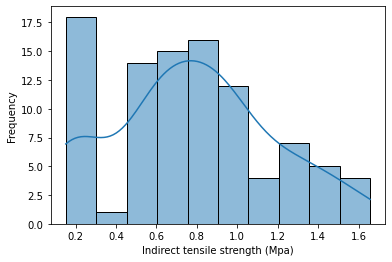

In [17]:
g = sns.histplot(data=y_train_new, x="y_train_unscaled", bins=10, kde=True)
g.set_ylabel('Frequency')
g.set_xlabel('Indirect tensile strength (Mpa)')
plt.show()

No handles with labels found to put in legend.


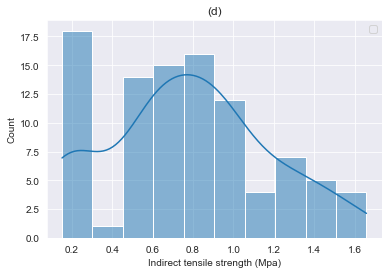

In [18]:
sns.set_style('darkgrid')
fig, ax = plt.subplots()
sns.histplot(x=y_train_new["y_train_unscaled"], bins=10, kde=True, ax = ax)
ax.set(xlabel='Indirect tensile strength (Mpa)')
ax.set_title('(d)')
ax.legend()
plt.show()

### 5.1 Model Evaluation
#### Linear Model

In [ ]:
param_grid = {'fit_intercept': [True, False],
            'positive': [True, False]}
grid = GridSearchCV(LinearRegression(), param_grid, cv = cv, scoring=['neg_mean_squared_error', 'r2'], refit = 'neg_mean_squared_error', return_train_score= True)
grid.fit(X_train, y_train)
printBestModelAdv(grid) 

#### Lasso Linear Model

In [ ]:
param_grid = {'alpha': [0.001,1, 10, 15, 30, 50, 100],
            'fit_intercept':[True, False],
            'positive': [True, False]}
grid = GridSearchCV(Lasso(), param_grid, cv=cv, scoring=['neg_mean_squared_error', 'r2'], refit = 'neg_mean_squared_error', return_train_score= True)
grid.fit(X_train, y_train)
printBestModelAdv(grid)

#### Ridge Linear Regression Model

In [ ]:
param_grid = {'alpha': [7, 8, 10,100],
'fit_intercept': [True, False],
'solver': [ 'svd', 'cholesky', 'lsqr', 'sparse_cg', 'sag', 'saga']}
grid = GridSearchCV(Ridge(), param_grid, cv=cv, scoring=['neg_mean_squared_error', 'r2'], refit = 'neg_mean_squared_error')
grid.fit(X_train, y_train)
printBestModelAdv(grid)

#### Linear elastic Net

In [ ]:
param_grid = {'alpha': [0.01,1,2,3,4],
'fit_intercept': [True, False]}
grid = GridSearchCV(ElasticNet(), param_grid, cv=cv, scoring=['neg_mean_squared_error', 'r2'], refit = 'neg_mean_squared_error')
grid.fit(X_train, y_train)
printBestModelAdv(grid)

#### Polynomial model

In [ ]:
def PolynomialRegression(degree=2, **kwargs):
    return make_pipeline(PolynomialFeatures(degree), LinearRegression(**kwargs))

param_grid = {'polynomialfeatures__degree': [2,3],
'linearregression__fit_intercept': [True, False],
'linearregression__positive':[True, False]}
grid = GridSearchCV(PolynomialRegression(), param_grid, cv=cv, scoring=['neg_mean_squared_error', 'r2'], refit = 'neg_mean_squared_error')
grid.fit(X_train, y_train)
printBestModelAdv(grid)

#### Lasso polynomial model

In [ ]:
def PolynomialRegression(degree=2, **kwargs):
    return make_pipeline(PolynomialFeatures(degree), Lasso(**kwargs))

param_grid = {'polynomialfeatures__degree': [2,3],
            'lasso__alpha': [1,2, 3, 10, 15, 30],
            'lasso__fit_intercept':[True, False],
            'lasso__positive': [True, False],
            'lasso__max_iter': [2000,3000, 3500]}
grid = GridSearchCV(PolynomialRegression(), param_grid, cv=cv, scoring=['neg_mean_squared_error', 'r2'], refit = 'neg_mean_squared_error', return_train_score= True)
grid.fit(X_train, y_train)
printBestModelAdv(grid)

#### Ridge Polynomial Model

In [ ]:
def PolynomialRegression(degree=2, **kwargs):
    return make_pipeline(PolynomialFeatures(degree), Ridge(**kwargs))

param_grid = {'polynomialfeatures__degree': [2,3],
'ridge__alpha':[20,30,50, 60],
'ridge__fit_intercept': [True, False],
'ridge__solver': [ 'lsqr', 'cholesky', 'sparse_cg', 'auto']}
grid = GridSearchCV(PolynomialRegression(), param_grid, cv=cv, scoring=['neg_mean_squared_error', 'r2'], refit='neg_mean_squared_error')
grid.fit(X_train, y_train)
printBestModelAdv(grid)

#### Support Vector Regression

In [ ]:
param_grid = {
    'kernel':['linear','rbf', 'sigmoid', 'poly'],
    'degree':[2,3,4],
    'C':[0.01,1,5,10],
    'epsilon':[0.1,0.2, 1, 1.5]
}
grid = GridSearchCV(SVR(), param_grid, cv=cv, scoring=['neg_mean_squared_error', 'r2'], refit='neg_mean_squared_error')
grid.fit(X_train, y_train)
printBestModelAdv(grid)

#### Decision tree regresor

In [ ]:
param_grid = {
    'max_depth':[1,2,3,5,10,30],
    'min_samples_split':[2,3,4],
    'min_samples_leaf':[0.4,1,2]
}
grid = GridSearchCV(DecisionTreeRegressor(), param_grid, cv=cv, scoring=['neg_mean_squared_error', 'r2'], refit='neg_mean_squared_error')
grid.fit(X_train, y_train)
printBestModelAdv(grid)

#### Random Forest

In [ ]:
param_grid = {
    'bootstrap': [True, False],
    'max_depth': [10, 20, 30, 40, 50, 60, 70, 80, 90, 100, None],
    'max_features': ['auto', 'sqrt'],
    'min_samples_leaf': [1, 2, 4],
    'min_samples_split': [2, 5, 10],
    'n_estimators': [200, 400, 600, 800, 1000, 1200, 1400, 1600, 1800, 2000]
}
grid = RandomizedSearchCV(RandomForestRegressor(), param_grid, cv=cv, scoring=['r2','neg_mean_squared_error'], refit='neg_mean_squared_error', n_iter=10,)
grid.fit(X_train, y_train)
printBestModelAdv(grid, RandomForestRegressor(**grid.best_params_), True)

#### Extra tree regressor

In [ ]:
param_grid = {
    'bootstrap': [True, False],
    'max_depth': [10, 20, 30, 40, 50, 60, 70, 80, 90, 100, None],
    'max_features': ['auto', 'sqrt'],
    'min_samples_leaf': [1, 2, 4],
    'min_samples_split': [2, 5, 10],
    'n_estimators': [200, 400, 600, 800, 1000, 1200, 1400, 1600, 1800, 2000]
}
grid = RandomizedSearchCV(ExtraTreesRegressor(), param_grid, cv=cv, scoring=['r2','neg_mean_squared_error'], refit='neg_mean_squared_error', n_iter=10)
grid.fit(X_train, y_train)
printBestModelAdv(grid, RandomForestRegressor(**grid.best_params_), True)

#### XG Boost Regressor

In [ ]:
param_grid = {
    'n_estimators': [100,200, 300, 500, 1000]
}
grid = GridSearchCV(XGBRegressor(random_state=123), param_grid, cv=cv, scoring=['neg_mean_squared_error', 'r2'], refit='neg_mean_squared_error')
grid.fit(X_train, y_train)
printBestModelAdv(grid, XGBRegressor(**grid.best_params_), True)

In [ ]:
X_train.columns

In [19]:
X_train2 = X_train.copy()
X_train2.rename(columns={'0.075':'Grad. Sieve size 0.075', '0.3':'Grad. Sieve size 0.3', '0.6':'Grad. Sieve size 0.6', '2.36':'Grad. Sieve size 2.36',                                '4.75':'Grad. Sieve size 4.75','9.5':'Grad. Sieve size 9.5', '12.5':'Grad. Sieve size 12.5', '19':'Grad. Sieve size 19', 
                        'Plastic particle size (mm)':'Plastic size', 'Mixing speed (RPM)':'Mixing speed',
                        'Mixing Time (hours)':'Mixing Time',
                        'Bitumen content in the sample':'Bitumen content', 'New Plastic Type_Nylon':'Plastic Type_Nylon',
                        'New Plastic Type_PE':'Plastic Type_PE', 'New Plastic Type_PET':'Plastic Type_PET', 'New Plastic Type_PP':'Plastic Type_PP',
                         'New Plastic Type_PS':'Plastic Type_PS','New Plastic Type_PU':'Plastic Type_PU', 'New Plastic Type_PVC':'Plastic Type_PVC',
                        'New Plastic Type_Plastic Mix':'Plastic Type_Plastic Mix', 'New Plastic Type_e-waste':'Plastic Type_e-waste' ,
                        'Consolidated bitumen penetration grade_50/70':'Bitumen grade_50/70',
                        'Consolidated bitumen penetration grade_70/100':'Bitumen grade_70/100',
       }, inplace=True)

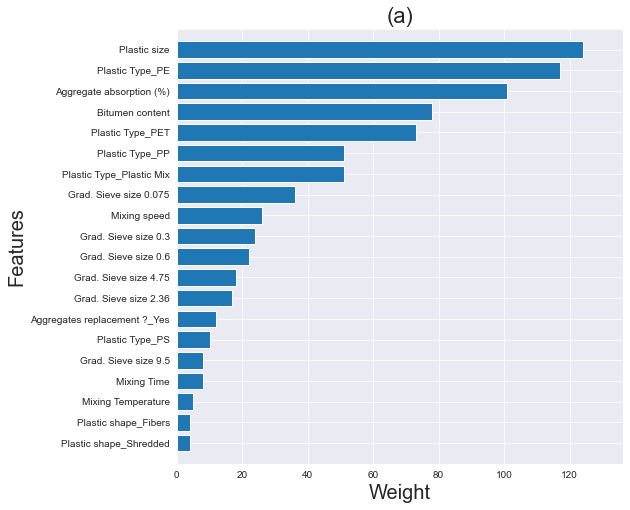

In [22]:
#Graph employed for selecting important features during tunning
XGBoostModel = XGBRegressor(random_state=123)
XGBoostModel.fit(X_train2,y_train)
ax = plot_importance(XGBoostModel, height=0.8, importance_type='weight', show_values=False, title=None, max_num_features = 20)
fig = ax.figure
plt.xlabel('Weight', fontsize=20)
plt.ylabel('Features', fontsize=20)
plt.title('(a)',fontsize= 22)
fig.set_size_inches(8,8)

## 6. Best Model Tunning

In [23]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=123)
cv = RepeatedKFold(n_splits = 5, n_repeats = 15, random_state = 123)

### 6.1. Feature selection

In [24]:
features_MSE = {}
def addMSE (columns, string):
    cv_results = cross_validate(XGBRegressor(random_state = 123), X_train[columns], y_train, cv = cv, scoring = ['neg_mean_squared_error'])
    MSE = np.average(-cv_results['test_neg_mean_squared_error'])
    features_MSE[string] = MSE

In [25]:
X_train.columns

Index(['Aggregate absorption (%)', '0.075', '0.3', '0.6', '2.36', '4.75',
       '9.5', '12.5', '19', 'Plastic particle size (mm)', 'Mixing speed (RPM)',
       'Mixing Temperature', 'Mixing Time (hours)',
       'Bitumen content in the sample', 'New Plastic Type_PE',
       'New Plastic Type_PET', 'New Plastic Type_PP', 'New Plastic Type_PS',
       'New Plastic Type_Plastic Mix',
       'Consolidated bitumen penetration grade_50/70',
       'Consolidated bitumen penetration grade_70/100',
       'Plastic pretreatment_Physical', 'Plastic pretreatment_Plastic Melted',
       'Plastic shape_Fibers', 'Plastic shape_Pellets',
       'Plastic shape_Shredded', 'Mixing Process_Dry', 'Mixing Process_Wet',
       'Aggregates replacement ?_Yes', 'Bitumen replacement?_Yes'],
      dtype='object')

In [26]:
addMSE(['Plastic particle size (mm)'], 
'Plastic size')

In [27]:
addMSE(['Plastic particle size (mm)',
        'New Plastic Type_PE', 'New Plastic Type_PET', 'New Plastic Type_PP', 'New Plastic Type_PS',
        'New Plastic Type_Plastic Mix'], 
'Plastic size \n Plastic type')

In [28]:
addMSE(['Plastic particle size (mm)',
        'New Plastic Type_PE', 'New Plastic Type_PET', 'New Plastic Type_PP', 'New Plastic Type_PS',
        'New Plastic Type_Plastic Mix',
        'Aggregate absorption (%)'], 
'Plastic size \n Plastic type \n Aggregates abs.')

In [29]:
addMSE(['Plastic particle size (mm)',
        'New Plastic Type_PE', 'New Plastic Type_PET', 'New Plastic Type_PP', 'New Plastic Type_PS',
        'New Plastic Type_Plastic Mix',
        'Aggregate absorption (%)', '0.075', '0.3', '0.6', '2.36', '4.75','9.5', '12.5', '19'], 
'Plastic size \n Plastic type \n Aggregates abs. \n Gradation')

In [30]:
addMSE(['Plastic particle size (mm)',
        'New Plastic Type_PE', 'New Plastic Type_PET', 'New Plastic Type_PP', 'New Plastic Type_PS',
        'New Plastic Type_Plastic Mix',
        'Aggregate absorption (%)', 'Bitumen content in the sample',
        '0.075', '0.3', '0.6', '2.36', '4.75','9.5', '12.5', '19'], 
'Plastic size \n Plastic type \n Aggregates abs. \n Gradation \n Bitumen cont.')

In [31]:
addMSE(['Plastic particle size (mm)',
        'New Plastic Type_PE', 'New Plastic Type_PET', 'New Plastic Type_PP', 'New Plastic Type_PS',
        'New Plastic Type_Plastic Mix',
        'Aggregate absorption (%)', 'Bitumen content in the sample',
        '0.075', '0.3', '0.6', '2.36', '4.75','9.5', '12.5', '19',
        'Mixing speed (RPM)'], 
'Plastic size \n Plastic type \n Aggregates abs. \n Bitumen cont. \n Gradation \n Mixing speed')

In [32]:
addMSE(['Plastic particle size (mm)',
        'New Plastic Type_PE', 'New Plastic Type_PET', 'New Plastic Type_PP', 'New Plastic Type_PS',
        'New Plastic Type_Plastic Mix',
        'Aggregate absorption (%)', 'Bitumen content in the sample',
        '0.075', '0.3', '0.6', '2.36', '4.75','9.5', '12.5', '19',
        'Mixing speed (RPM)',
        'Aggregates replacement ?_Yes'], 
'Plastic size \n Plastic type \n Aggregates abs. \n Bitumen cont. \n Gradation \n Mixing speed \n Aggregates repl.')

In [33]:
addMSE(['Plastic particle size (mm)',
        'New Plastic Type_PE', 'New Plastic Type_PET', 'New Plastic Type_PP', 'New Plastic Type_PS',
        'New Plastic Type_Plastic Mix',
        'Aggregate absorption (%)', 'Bitumen content in the sample',
        '0.075', '0.3', '0.6', '2.36', '4.75','9.5', '12.5', '19',
        'Mixing speed (RPM)',
        'Aggregates replacement ?_Yes',
        'Mixing Process_Dry', 'Mixing Process_Wet'], 
'Plastic size \n Plastic type \n Aggregates abs. \n Bitumen cont. \n Gradation \n Mixing speed \n Aggregates repl. \n Mixing type')

In [34]:
addMSE(['Aggregate absorption (%)', '0.075', '0.3', '0.6', '2.36', '4.75',
       '9.5', '12.5', '19', 'Plastic particle size (mm)', 'Mixing speed (RPM)',
       'Mixing Temperature', 'Mixing Time (hours)',
       'Bitumen content in the sample', 'New Plastic Type_PE',
       'New Plastic Type_PET', 'New Plastic Type_PP', 'New Plastic Type_PS',
       'New Plastic Type_Plastic Mix',
       'Consolidated bitumen penetration grade_50/70',
       'Consolidated bitumen penetration grade_70/100',
       'Plastic pretreatment_Physical', 'Plastic pretreatment_Plastic Melted',
       'Plastic shape_Fibers', 'Plastic shape_Pellets',
       'Plastic shape_Shredded', 'Mixing Process_Dry', 'Mixing Process_Wet',
       'Aggregates replacement ?_Yes', 'Bitumen replacement?_Yes'], 
    'All features')

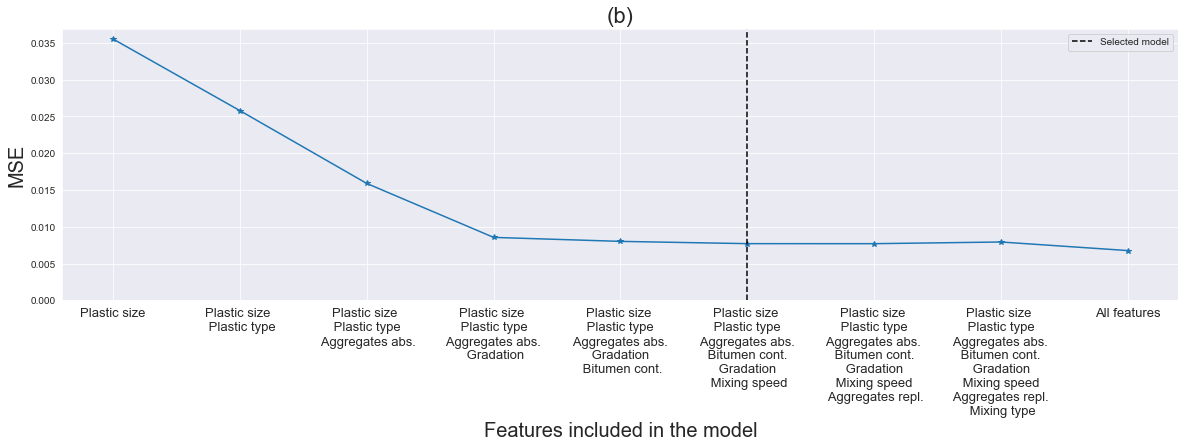

In [36]:
plt.rcParams["figure.figsize"] = (20,5)
plt.plot(features_MSE.keys(), features_MSE.values(), marker = '*') 
plt.ylim(ymin = 0)
plt.axvline(x='Plastic size \n Plastic type \n Aggregates abs. \n Bitumen cont. \n Gradation \n Mixing speed', ymin=0, ymax=1, color = 'k', ls = '--' , label='Selected model')
plt.ylabel('MSE', fontsize=20)
plt.xlabel('Features included in the model', fontsize=20)
plt.xticks(fontsize= 13)
plt.title('(b)', fontsize=22) 
plt.legend()
plt.show()

The features most approppiate for the model are aggregates gradation, bitumen content, plastic type, plastic addition.
### 6.2 Model Tunning

In [14]:
X_train = X_train[['Plastic particle size (mm)',
        'New Plastic Type_PE', 'New Plastic Type_PET', 'New Plastic Type_PP', 'New Plastic Type_PS',
        'New Plastic Type_Plastic Mix',
        'Aggregate absorption (%)', 'Bitumen content in the sample',
        '0.075', '0.3', '0.6', '2.36', '4.75','9.5', '12.5', '19',
        'Mixing speed (RPM)']]
X_test = X_test[['Plastic particle size (mm)',
        'New Plastic Type_PE', 'New Plastic Type_PET', 'New Plastic Type_PP', 'New Plastic Type_PS',
        'New Plastic Type_Plastic Mix',
        'Aggregate absorption (%)', 'Bitumen content in the sample',
        '0.075', '0.3', '0.6', '2.36', '4.75','9.5', '12.5', '19',
        'Mixing speed (RPM)']]

### 6.3 Final model evaluation on test set

In [15]:
def modelEvaluation (model, Title):
    min = dfITSCleanedImputed['ITS of the sample [Mpa]'].min()
    max = dfITSCleanedImputed['ITS of the sample [Mpa]'].max()
    #Model Fitting
    model.fit(X_train, y_train)
    predictions_test = model.predict(X_test)
    #Model Evaluation
    r2_test = r2_score(y_test, predictions_test)
    mse_test = mean_squared_error(y_test, predictions_test)
    rmse_test_unscaled = (math.sqrt(mse_test)*(max-min))+min
    plt.figure(figsize=(7,7))
    #Model Plotting
    plt.scatter(y_test, predictions_test, c='crimson')
    plt.plot([(1,1), (0,0)], [(1,1), (0,0)], 'b-')
    plt.xlabel('True Values', fontsize=15)
    plt.xlim (0.1,1)
    plt.ylim (0.1,1)
    plt.ylabel('Predictions - ' + Title, fontsize=18)
    plt.annotate('R2 = '+str(round(r2_test,3)), xy = (0.6,0.3), fontweight = 'bold', fontsize = 'xx-large')
    plt.annotate('RMSE = '+str(round(rmse_test_unscaled,3)), xy = (0.6,0.25), fontweight = 'bold', fontsize = 'xx-large')
    plt.show()
    return predictions_test

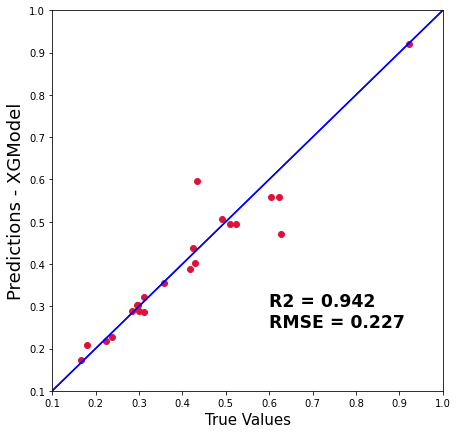

In [16]:
XGModel = XGBRegressor(random_state = 123)
prediction_XGModel = modelEvaluation(XGModel, 'XGModel')

In [ ]:
XGModel.get_params

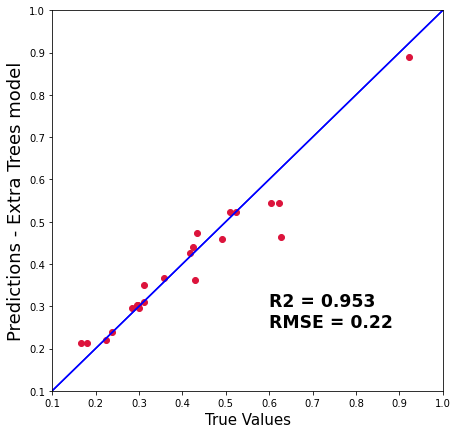

In [17]:
extraTreeModel = ExtraTreesRegressor(n_estimators=400, min_samples_split=5,min_samples_leaf=2, max_features='auto', max_depth=100,bootstrap=False, random_state=123)
prediction_ExtraTrees = modelEvaluation(extraTreeModel, 'Extra Trees model')

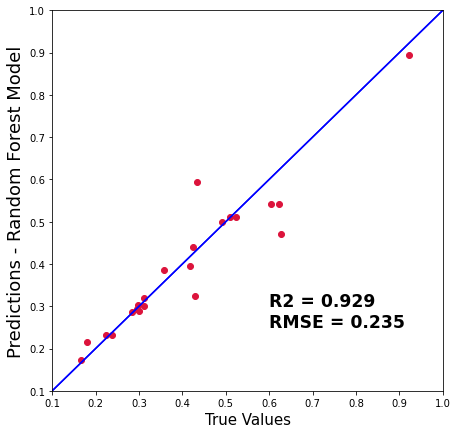

In [18]:
RFModel = RandomForestRegressor(n_estimators=2000,min_samples_split=2, min_samples_leaf=1, max_features='sqrt', max_depth=10, bootstrap=False, random_state=123)
prediction_RandomForest = modelEvaluation(RFModel, 'Random Forest Model')

## 6.3 ANOVA Analysis

In [21]:
df_predictions = y_test.to_frame(name='real_Y')
df_predictions['XGModel_predictions'] = prediction_XGModel
df_predictions['ExtraTrees_predictions'] = prediction_ExtraTrees
df_predictions['RandomForest_predictions'] = prediction_RandomForest
def normalityTest (model, data, alpha=0.05):
    k2, p = stats.normaltest(data)
    if p > alpha:
        print ('The ' + model + ' is probably Gaussian. p-value = ' + str(p))
    else:
        print ('The ' + model +' is not probably Gaussian. p-value = '+ str(p))

In [ ]:
normalityTest(data = df_predictions['real_Y'], model = 'real values')
normalityTest(data = df_predictions['RandomForest_predictions'], model = 'Random Forest')
normalityTest(data = df_predictions['XGModel_predictions'], model = 'XG model')
normalityTest(data = df_predictions['ExtraTrees_predictions'], model = 'Extra trees')

### Variance homogeneity (Bartlett's test) 

In [ ]:
stal, p = stats.bartlett(df_predictions['real_Y'], df_predictions['RandomForest_predictions'], df_predictions['XGModel_predictions'], df_predictions['ExtraTrees_predictions'])
if p > 0.05:
    print('There is not sufficient evidence to say that the variance of the real values and the predictors are differents. The p-value is ' + str(p))
else:
    print('There is non-homogeneity in the variance. The p-value is ' + str(p))

In [ ]:
stats.f_oneway(df_predictions['real_Y'],
               df_predictions['RandomForest_predictions'],
               df_predictions['XGModel_predictions'],
               df_predictions['ExtraTrees_predictions'])

There is not statistical differences between the predicted values by the three models and the observed values

## 6.4 Goodness of fit Analysis

In [ ]:
def evaluateGOF (y_real, model_predictions, Model, alpha = 0.05):
    stat, p_value  = stats.ks_2samp(y_real, model_predictions, alternative='two-sided')
    if p_value > 0.05:
        print ('The real values and the predictions of '+Model+' come from the same distribution according to the Kolmogorov-Smirnov test. The p-value is '+str(p_value))
    else:
        print ('The real values and the predictions of '+Model+'DO NOT come from the same distribution. The p-value is '+str(p_value))

In [ ]:
evaluateGOF(y_real=df_predictions['real_Y'], model_predictions=df_predictions['RandomForest_predictions'], Model = 'Random Forest')
evaluateGOF(y_real=df_predictions['real_Y'], model_predictions=df_predictions['XGModel_predictions'], Model = 'Boosted Tree')
evaluateGOF(y_real=df_predictions['real_Y'], model_predictions=df_predictions['ExtraTrees_predictions'], Model = 'Extra treees')

In [23]:
df_predictions.to_clipboard()

In [30]:
X_test.loc[[24]]

,Plastic particle size (mm),New Plastic Type_PE,New Plastic Type_PET,New Plastic Type_PP,New Plastic Type_PS,New Plastic Type_Plastic Mix,Aggregate absorption (%),Bitumen content in the sample,0.075,0.3,0.6,2.36,4.75,9.5,12.5,19,Mixing speed (RPM)
24,0.05048,0.1,0.0,0.0,0.0,0.0,0.430769,0.505837,0.442623,0.40678,0.448264,0.67725,0.700827,0.284666,0.272255,1.0,0.0
